# Report for the Deep Learning Course
This is a template notebook of your report. Please complete your report with your teammate following these instructions:
- **Rename your notebook** in the format `FirstName1FAMILYNAME1_FirstName2FAMILYNAME2_report2.ipynb`. For example, when the team consists of Johann FAOUZI and Ikko YAMANE, the file name should look like `JohannFAOUZI_IkkoYAMANE_report2.ipynb`.
- Answer in English.
- Please submit your notebook on Moodle.
- The submission deadline is 18:00 (UTC+2) of December 15, 2024.


**Remarks**:
- The accuracy of your models is not important for the evaluation, but I expect the performance is at least better than a random guess or a constant predictor.
- I encourage you to explain your problem setups/code/algorithms/archtectures/methods/tools/results with Python comments or Markdown text. You can use figures, plots, or other visualization techniques. The quality of explanations will be great part of the evaluation.
- Needless to say, do not copy solutions from other students.
- If your code is based on any articles, code examples, or web pages, **clearly mention the references and how you used them**.
- Likewise, if you use AI tools, clearly explain how you used them and which parts of your answers were given by the AIs, and make sure that you check and understand those parts yourself.
- If I detect any work copied from anywhere else without acknowledging it, your grade will get a **significant penalty**.

## Question 0
Enter your information below.
- Name of Author 1: COMBY Killian
- Name of Author 2: DELMARE Bastien
- Email address of Author 1: killian.comby@eleve.ensai.fr
- Email address of Author 2: bastien.delmare@eleve.ensai.fr

## Question 1 (Noun-Verb Classification)

Train two different classifiers for the Noun-Verb dataset [1], which we have seen in the ateliers, and compare their performance.

---
**References**

[1] Ali Elkahky and Kellie Webster and Daniel Andor and Emily Pitler. A Challenge Set and Methods for Noun-Verb Ambiguity, In *Proceedings of EMNLP*, 2018.

Importation de la table : 

In [2]:
!pip install pyconll 
def load_dataset(path='data'):
    """Load the noun verb dataset.

    Parameters
    ----------
    path : str
        Path to the directory.

    Returns
    -------
    train : Conll
        Training set.

    validation : Conll
        Validation set.

    test : Conll
        Test set.

    """
    import os
    import pyconll
    from urllib.request import urlretrieve

    if not os.path.exists(path):
        os.makedirs(path)
    
    files = ('train.conll', 'dev.conll', 'test.conll')

    # Downloads the files if necessary
    for file in files:
        if not os.path.isfile(os.path.join(path, file)):
            url = f'https://raw.githubusercontent.com/google-research-datasets/noun-verb/master/{file}'
            urlretrieve(url, os.path.join(path, file))

    return (pyconll.load_from_file(os.path.join(path, file)) for file in files)

train, validation, test = load_dataset()

In [ ]:
import numpy as np
import torch


def load_embeddings(path='data'):
    """Load the GloVe 50d embeddings.

    Parameters
    ----------
    path : str
        Path to the directory.

    Returns
    -------
    embeddings : dict
        GloVe embeddings.

    """
    import os
    import gzip
    import shutil

    # Download the file if necessary
    if not os.path.isfile(os.path.join(path, 'glove.6B.50d.txt')):
        from urllib.request import urlretrieve

        if not os.path.exists(path):
            os.makedirs(path)
        path2glove = os.path.join(path, 'glove.6B.50d.txt.gz')

        # url = (
        #     'https://media.githubusercontent.com/media/johannfaouzi/'
        #     'deep-learning-ensai/main/PS3/data/glove.6B.50d.txt'
        # )
        url = ('https://github.com/uclnlp/inferbeddings/raw/refs/heads/master/'
               'data/glove/glove.6B.50d.txt.gz')
        urlretrieve(url, path2glove)

    with gzip.open(path2glove, 'rb') as f_in:
        with open('./glove.6B.50d.txt', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Save the results in a dictionary
    embeddings = {}

    # Get the embedding for each token in the file
    with open('./glove.6B.50d.txt', 'r') as file:
        for line in file.readlines():
            split = line.strip().split(' ')
            token = split[0]
            value = torch.from_numpy(np.array(split[1:], dtype=np.float32))
            embeddings[token] = value

    # print(list(embeddings.items())[0])
    # print(list(embeddings.items())[-1])

    # Define the mean embedding for out-of-vocabulary token
    embeddings['out_of_vocabulary'] = torch.concat(
        [embedding.reshape(1, -1) for embedding in embeddings.values()], 0).mean(0)

    return embeddings

embeddings = load_embeddings()

In [ ]:
def preprocess_dataset(dataset):
    """Preprocess a dataset.

    Parameters
    ----------
    dataset : Conll
        Dataset.

    Returns
    -------
    X : list[Tensors]
        Preprocessed sentences.

    y : Tensor
        Preprocessed labels.

    index : Tensor
        Indices of the tokens to predict.

    """

    X = []
    y = []
    index = []

    label_mapping = {'NON-VERB': 0, 'VERB': 1}

    for sentence in dataset:

        embedded_sentence = []
        label = None
        idx = None

        for i, token in enumerate(sentence):

            # Get the token in lower cases
            token_lower = token.form.lower()

            # Get the embedding of the token
            if token_lower in embeddings.keys():
                embedded_sentence.append(embeddings[token_lower].reshape(1, -1))
            else:
                embedded_sentence.append(embeddings['out_of_vocabulary'].reshape(1, -1))

            # Get the label (if any)
            if len(token.feats):
                if label is not None:
                    raise ValueError("Two annotated tokens in a single sentence.")
                label = label_mapping[next(iter(token.feats['POS']))]
                idx = i

        # Add the preprocessed sample to the dataset only if there is a label available
        if label is not None:
            X.append(torch.concat(embedded_sentence))
            y.append(label)
            index.append(idx)

    y = torch.tensor(y).to(dtype=torch.float32)
    index = torch.tensor(index).to(dtype=torch.int64)

    return X, index, y

X_train, index_train, y_train = preprocess_dataset(train)
X_val, index_val, y_val = preprocess_dataset(validation)
X_test, index_test, y_test = preprocess_dataset(test)

On compare un CNN et un LSTM pour classifier : 


Entraînement du modèle CNN
Epoch 5/15:
Train Loss: 0.3610, Test Loss: 0.6543
Epoch 10/15:
Train Loss: 0.1569, Test Loss: 0.9765
Epoch 15/15:
Train Loss: 0.1108, Test Loss: 1.1908

Entraînement du modèle LSTM
Epoch 5/15:
Train Loss: 0.4386, Test Loss: 0.6997
Epoch 10/15:
Train Loss: 0.2291, Test Loss: 0.8708
Epoch 15/15:
Train Loss: 0.1480, Test Loss: 1.0784


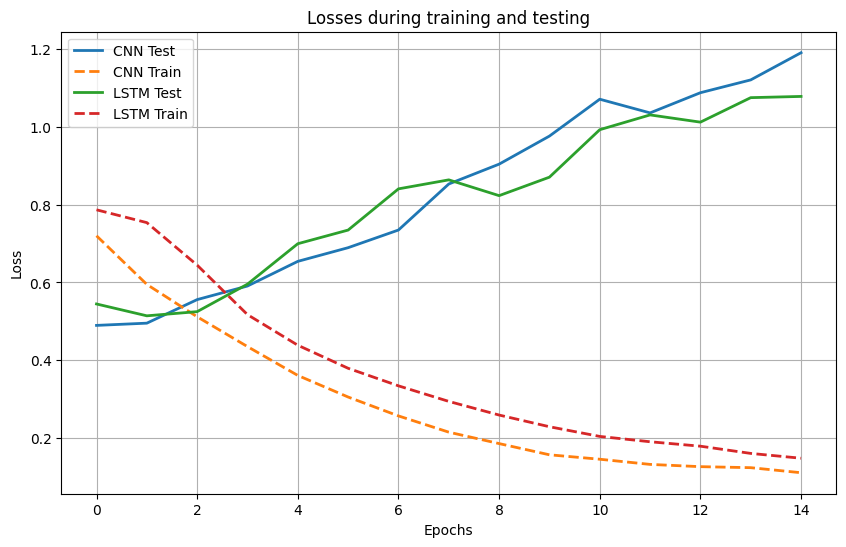

In [3]:
class CNNClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes, kernel_sizes=[3, 4, 5], num_filters=100):
        super(CNNClassifier, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, 
                      out_channels=num_filters, 
                      kernel_size=k) 
            for k in kernel_sizes
        ])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, X, index):
        # X: List of tensors (batch of sequences)
        # Convert list to padded tensor
        X = nn.utils.rnn.pad_sequence(X, batch_first=True).permute(0, 2, 1)  # Shape: (batch_size, embedding_dim, seq_length)

        # Apply convolutions and ReLU
        conv_outs = [torch.relu(conv(X)) for conv in self.convs]  # Each conv_out: (batch_size, num_filters, *)
        
        # Apply Global Max Pooling
        pooled = [torch.max(out, dim=2).values for out in conv_outs]  # Shape: (batch_size, num_filters)

        # Concatenate pooled outputs
        concat = torch.cat(pooled, dim=1)  # Shape: (batch_size, num_filters * len(kernel_sizes))

        # Fully connected layer
        output = self.fc(self.dropout(concat))  # Shape: (batch_size, num_classes)
        return output
    
class GRUNetwork(nn.Module):
    def __init__(self, dim_word, n_hidden=100):
        super().__init__()
        self.gru = nn.GRU(dim_word, n_hidden, bidirectional=True)
        self.linear = nn.Linear(2 * n_hidden, 1)


    def forward(self, X, index):
        """Forward method.

        Parameters
        ----------
        X : list[Tensors], len = batch_size
            Sequence of embeddings.

        index : tensor, shape = (batch_size,)
            Index of the token of interest in each sequence.

        Returns
        -------
        y : tensor, shape = (batch_size,)
            Logits.

        """
        # Get the length of each sequence
        lens = [sequence.size()[0] for sequence in X]

        # Pad the list of tensors
        X_padded = pad_sequence(X)

        # Pack the padded sequence
        X_packed = pack_padded_sequence(X_padded, lens, enforce_sorted=False)

        # Apply the GRU
        output_packed, _ = self.gru(X_packed)

        # Unpack the output of the GRU
        output_unpacked, _ = pad_packed_sequence(output_packed)

        # Get the hidden state for the token of interest
        h = torch.concat([output_unpacked[idx, i].reshape(1, -1) for i, idx in enumerate(index)])

        # Apply the linear layer
        y = torch.squeeze(self.linear(h))

        return y

In [ ]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, X, y, index):
        self.X = X
        self.y = y
        self.index = index

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.index[idx]


dataloader_train = DataLoader(
    CustomDataset(X_train, y_train, index_train),
    batch_size=64, shuffle=True, collate_fn=lambda x: x
)

dataloader_val = DataLoader(
    CustomDataset(X_val, y_val, index_val),
    batch_size=64, shuffle=True, collate_fn=lambda x: x
)

dataloader_test = DataLoader(
    CustomDataset(X_test, y_test, index_test),
    batch_size=64, shuffle=True, collate_fn=lambda x: x
)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for batch in dataloader:
        # Extraction des données
        X = [item[0].to(device) for item in batch]  # Liste des embeddings
        y = torch.tensor([item[1] for item in batch]).to(device)  # Labels
        index = torch.tensor([item[2] for item in batch]).to(device)  # Indices

        # Forward pass
        pred = model(X, index).squeeze(1)  # Réduit la dimension des prédictions à (batch_size)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f"Loss: {loss.item()}")



def eval_loop(dataloader, model, loss_fn, device):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0., 0.

    with torch.no_grad():
        for batch in dataloader:

            X = [item[0].to(device) for item in batch]
            y = torch.tensor([item[1] for item in batch]).to(device)
            index = torch.tensor([item[2] for item in batch]).to(device)

            pred = model(X, index).squeeze(1)
            loss += loss_fn(pred, y).item()
            correct += ((pred > 0) == y).type(torch.float).sum().item()


    loss /= num_batches
    correct /= size
    return loss, correct

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

def train_loop_gru(dataloader, model, loss_fn, optimizer, device):

    model.train()

    for batch in dataloader:

        # Reset gradients
        optimizer.zero_grad()

        X = [item[0].to(device) for item in batch]
        y = torch.tensor([item[1] for item in batch]).to(device)
        index = torch.tensor([item[2] for item in batch]).to(device)

        # Forward
        pred = model(X, index)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()



def eval_loop_gru(dataloader, model, loss_fn, device):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0., 0.

    with torch.no_grad():
        for batch in dataloader:

            X = [item[0].to(device) for item in batch]
            y = torch.tensor([item[1] for item in batch]).to(device)
            index = torch.tensor([item[2] for item in batch]).to(device)

            pred = model(X, index)
            loss += loss_fn(pred, y).item()
            correct += ((pred > 0) == y).type(torch.float).sum().item()
            


    loss /= num_batches
    correct /= size
    return loss, correct

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Initialisation des variables pour stocker les accuracies et les pertes
cnn_train_acc, cnn_val_acc = [], []
gru_train_acc, gru_val_acc = [], []

cnn_train_loss, cnn_val_loss = [], []
gru_train_loss, gru_val_loss = [], []

# Initialisation des modèles
embedding_dim = 50  # Dimension des embeddings GloVe
num_classes = 1     # Pour une classification binaire

cnn_model = CNNClassifier(embedding_dim=embedding_dim, num_classes=num_classes).to(device)
gru_model = GRUNetwork(dim_word=embedding_dim).to(device)

loss_fn = nn.BCEWithLogitsLoss()

# Optimizers spécifiques à chaque modèle
cnn_optimizer = torch.optim.Adam(cnn_model.parameters())
gru_optimizer = torch.optim.Adam(gru_model.parameters())

epochs = 20

# Entraînement et évaluation pour le CNN
for t in range(epochs):
    print(f"Epoch {t + 1} (CNN)\n-------------------------------------------------")

    # Train loop pour le CNN
    train_loop(dataloader_train, cnn_model, loss_fn, cnn_optimizer, device)

    # Evaluation loop pour le CNN
    loss_train_cnn, accuracy_train_cnn = eval_loop(dataloader_train, cnn_model, loss_fn, device)
    print(f"Training set:   Accuracy: {(100 * accuracy_train_cnn): >0.1f}%, Avg loss: {loss_train_cnn: >8f}")
    cnn_train_loss.append(loss_train_cnn)
    cnn_train_acc.append(accuracy_train_cnn)

    loss_val_cnn, accuracy_val_cnn = eval_loop(dataloader_val, cnn_model, loss_fn, device)
    print(f"Validation set: Accuracy: {(100 * accuracy_val_cnn): >0.1f}%, Avg loss: {loss_val_cnn: >8f}\n")
    cnn_val_loss.append(loss_val_cnn)
    cnn_val_acc.append(accuracy_val_cnn)

print("CNN Done!")

# Entraînement et évaluation pour le GRU
for t in range(epochs):
    print(f"Epoch {t + 1} (GRU)\n-------------------------------------------------")

    # Train loop pour le GRU
    train_loop_gru(dataloader_train, gru_model, loss_fn, gru_optimizer, device)

    # Evaluation loop pour le GRU
    loss_train_gru, accuracy_train_gru = eval_loop_gru(dataloader_train, gru_model, loss_fn, device)
    print(f"Training set:   Accuracy: {(100 * accuracy_train_gru): >0.1f}%, Avg loss: {loss_train_gru: >8f}")
    gru_train_loss.append(loss_train_gru)
    gru_train_acc.append(accuracy_train_gru)

    loss_val_gru, accuracy_val_gru = eval_loop_gru(dataloader_val, gru_model, loss_fn, device)
    print(f"Validation set: Accuracy: {(100 * accuracy_val_gru): >0.1f}%, Avg loss: {loss_val_gru: >8f}\n")
    gru_val_loss.append(loss_val_gru)
    gru_val_acc.append(accuracy_val_gru)

print("GRU Done!")

# Plotting
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 10))

# Subplot 1: Accuracy
plt.subplot(2, 1, 1)
plt.plot(epochs_range, cnn_train_acc, label="CNN Training Accuracy", linestyle="--", color="b")
plt.plot(epochs_range, cnn_val_acc, label="CNN Validation Accuracy", color="b")
plt.plot(epochs_range, gru_train_acc, label="GRU Training Accuracy", linestyle="--", color="r")
plt.plot(epochs_range, gru_val_acc, label="GRU Validation Accuracy", color="r")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.grid(True)

# Subplot 2: Loss
plt.subplot(2, 1, 2)
plt.plot(epochs_range, cnn_train_loss, label="CNN Training Loss", linestyle="--", color="b")
plt.plot(epochs_range, cnn_val_loss, label="CNN Validation Loss", color="b")
plt.plot(epochs_range, gru_train_loss, label="GRU Training Loss", linestyle="--", color="r")
plt.plot(epochs_range, gru_val_loss, label="GRU Validation Loss", color="r")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Question 2 (Food Image Classification)

By adapting the LeNet-5 [3], train a simple classifier for a resized version of the [Food-7 dataset](https://huggingface.co/datasets/cv-talks/food-7) dataset, which is a subset of the Food-101 dataset [2].

Execute the following five code cells to load the dataset.

---
**References**

[2] Bossard, Lukas; Guillaumin, Matthieu; Van Gool, Luc. Food-101 -- Mining Discriminative Components with Random Forests,
_European Conference on Computer Vision_, 2014.
URL: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/.


[3] Lecun, Yann; Bottou, Léon; Bengio, Yoshua; Haffner, Patrick. "Gradient-based learning applied to document recognition" (PDF). _Proceedings of the IEEE_. 86 (11): 2278–2324, 1998.

In [1]:
!pip install datasets[vision]
!pip install gdown

zsh:1: no matches found: datasets[vision]


In [2]:
import os
import gdown
import zipfile
from datasets import load_from_disk


def download_food7(path='data/food'):
    filename = 'food7_34x34.zip'
    gdriveid = '1eZFfl8MUSN_WeovPkxR0_R7DS7TzQrxk'

    if not os.path.exists(path):
        os.makedirs(path)

    filepath = os.path.join(path, filename)
    if not os.path.isfile(filepath):
        gdown.download(id=gdriveid, output=filepath, quiet=False)


def load_food7(path='data/food'):
    filename = 'food7_34x34.zip'
    filepath = os.path.join(path, filename)
    with zipfile.ZipFile(filepath, 'r') as f:
        f.extractall(path)

    ds = load_from_disk(path)
    label_names = ds.features['label'].names
    class2name = {i: label_names[i] for i in range(len(label_names))}

    return ds, class2name


download_food7()
ds_food7, class2name = load_food7()

/home/ensai/Documents/ENSAI/3A/Deep learning/DM_deep/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Split the dataset to train (size 6000) and test (size 1000) splits.

from torch.utils.data import random_split

train_size = 6000
test_size = 1000

ds_food7_split = ds_food7.train_test_split(
    train_size=train_size,
    test_size=test_size,
    stratify_by_column='label'
)

In [4]:
# Prepare dataloaders.

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as tvtf

def collate_fn1(minibatch):
    """ Transform each minibatch.
    """
    images = []
    labels = []
    for example in minibatch:
        images.append(example["image"])
        labels.append(example["label"])

    return torch.tensor(images), torch.tensor(labels)

dataloader_train = DataLoader(ds_food7_split['train'], collate_fn=collate_fn1, batch_size=32)
dataloader_test = DataLoader(ds_food7_split['test'], collate_fn=collate_fn1, batch_size=128)

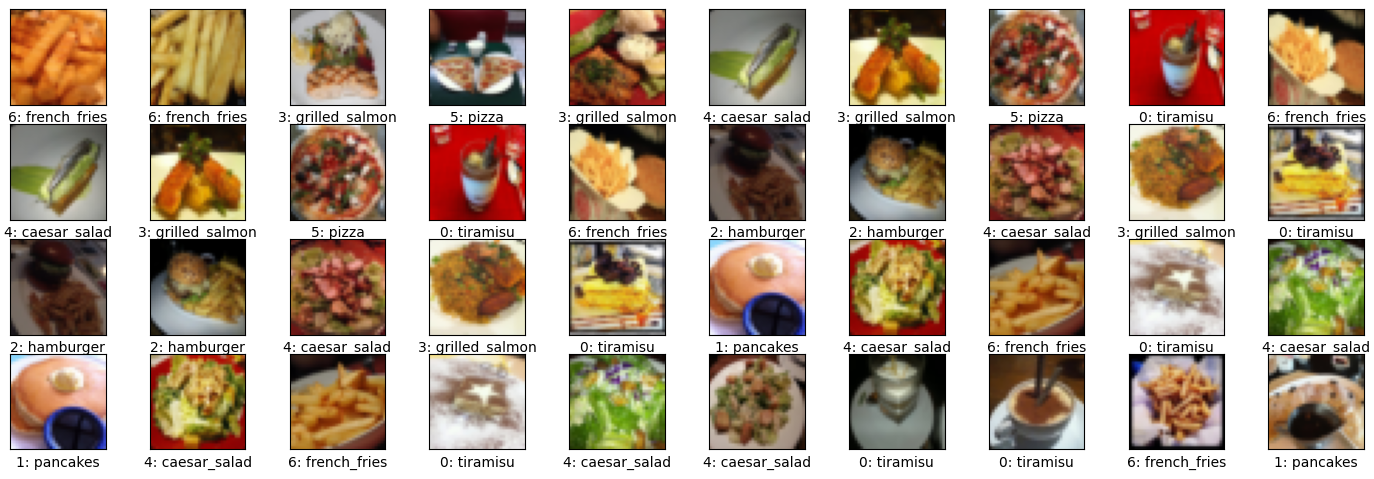

In [5]:
# Show example images.

import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_example_images(dataset):
    nrow = 4
    ncol = 10
    fig, ax = plt.subplots(nrow, ncol, figsize=(10, 4))

    X, y = next(iter(DataLoader(
            ds_food7,
            collate_fn=collate_fn1,
            batch_size=nrow * ncol,
            shuffle=True)))

    for i in range(nrow):
        for j in range(ncol):
            # img = minibatch['image'][5*i + j]
            # label = minibatch['label'][5*i + j]
            img = X[5*i + j]
            label = y[5*i + j]
            ax[i][j].imshow(np.transpose(img, [1, 2, 0]))
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel(f'{label.item()}: {class2name[label.item()]}')

    fig.subplots_adjust(bottom=0.1, right=1.5, top=1.2)

show_example_images(dataset=ds_food7)

### How to use the Food-7 dataset

After executing the previous five cells, you will get the following objects.

- `dataloader_train`: `torch.data.util.Dataloader` object holding the training split of the dataset. The size is 6000.

- `dataloader_test`: `torch.data.util.Dataloader` object holding the test split of the dataset. The size is 1000.

- `class2name`: Python dictionary to map a numerically represented class to its name. For example, `class2name[0] == 'tiramisu'`.

- `ds_food7`: the Hugging Face `datasets.Dataset` object storing the whole dataset.

Each image has 3 channels and is of size $34 \times 34$. There are 7 classes. See the last code cell to learn how to use the dataloader.

Nous construisons ici le modèle LeNet-5 : 

Epoch 1/15, Train Loss: 1.9323, Test Loss: 1.8389
Correct Predictions: 276, Incorrect Predictions: 724
Epoch 2/15, Train Loss: 1.8208, Test Loss: 1.7775
Correct Predictions: 323, Incorrect Predictions: 677
Epoch 3/15, Train Loss: 1.7821, Test Loss: 1.7670
Correct Predictions: 339, Incorrect Predictions: 661
Epoch 4/15, Train Loss: 1.7541, Test Loss: 1.7131
Correct Predictions: 346, Incorrect Predictions: 654
Epoch 5/15, Train Loss: 1.6743, Test Loss: 1.6499
Correct Predictions: 399, Incorrect Predictions: 601
Epoch 6/15, Train Loss: 1.6212, Test Loss: 1.6217
Correct Predictions: 404, Incorrect Predictions: 596
Epoch 7/15, Train Loss: 1.5971, Test Loss: 1.6072
Correct Predictions: 415, Incorrect Predictions: 585
Epoch 8/15, Train Loss: 1.5796, Test Loss: 1.6015
Correct Predictions: 420, Incorrect Predictions: 580
Epoch 9/15, Train Loss: 1.5635, Test Loss: 1.5953
Correct Predictions: 415, Incorrect Predictions: 585
Epoch 10/15, Train Loss: 1.5482, Test Loss: 1.5876
Correct Predictions: 4

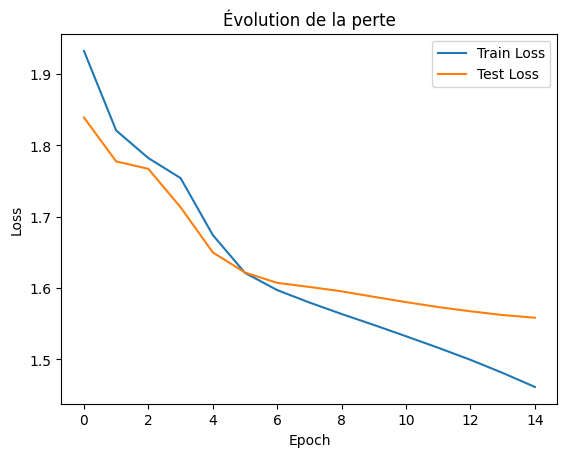

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


class LeNet5Food7(nn.Module):
    def __init__(self, num_classes=7):
        super(LeNet5Food7, self).__init__()

        # C1: 6 feature maps, kernel 5x5, stride 1  
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)  # Input: 34x34x3 -> Output: 30x30x6
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling S2: 30x30 -> 15x15

        # C3: 16 feature maps, kernel 5x5, connected to subsets of S2 maps
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # Input: 15x15x6 -> Output: 11x11x16
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Subsampling S4: 11x11 -> 5x5

        # C5: Fully connected convolutional layer
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)  # Input: 5x5x16 -> Output: 1x1x120

        # F6: Fully connected layer + activation
        self.fc1 = nn.Linear(120, 84)  # Flattened input -> Fully connected layer
        self.custom_activation = lambda x: 1.7159 * torch.tanh((1 * x))

        # Output layer (RBF replaced with a simple FC for PyTorch)
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        # Forward propagation through layers
        x = torch.sigmoid(self.conv1(x))  # C1
        x = self.pool1(x)  # S2

        x = torch.tanh(self.conv2(x))  # C3
        x = self.pool2(x)  # S4

        x = torch.tanh(self.conv3(x))  # C5

        x = x.view(-1, 120)  # Flatten
        x = self.custom_activation(self.fc1(x))  # F6

        x = self.fc2(x)  # Output layer
        return x


# Création du modèle
model = LeNet5Food7(num_classes=7)

# Définir la perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Fonction d'entraînement mise à jour avec métriques de performance
def train_model_with_metrics(model, dataloader_train, dataloader_test, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Phase d'entraînement
        model.train()
        running_loss = 0.0

        for images, labels in dataloader_train:
            images, labels = images.to(device), labels.to(device)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(dataloader_train))

        # Phase de test (évaluation)
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in dataloader_test:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                # Prédictions
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_losses.append(test_loss / len(dataloader_test))

        # Afficher les métriques de performance
        incorrect = total - correct
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
        print(f"Correct Predictions: {correct}, Incorrect Predictions: {incorrect}")

    return train_losses, test_losses


# Le reste du code reste inchangé
train_losses, test_losses = train_model_with_metrics(model, dataloader_train, dataloader_test, num_epochs=15)

# Affichage de la courbe de perte
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Évolution de la perte")
plt.legend()
plt.show()


## Question 3 (Small Project)
Find a dataset that has not appeared in the course and apply any method that we have learned (or any deep learning method that you have discovered yourself).


Nous nous concentrons sur la base de données MNIST et cherchons à mettre en place un réseau de Koopeman : 

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 852kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 308kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.76MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.19MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/30], Loss: 0.1512
Epoch [2/30], Loss: 0.0730
Epoch [3/30], Loss: 0.0576
Epoch [4/30], Loss: 0.0492
Epoch [5/30], Loss: 0.0445


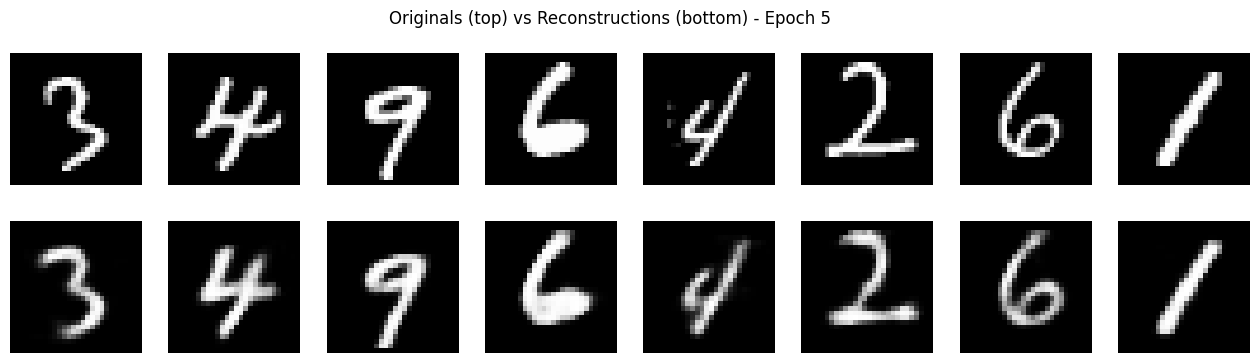

Epoch [6/30], Loss: 0.0413
Epoch [7/30], Loss: 0.0386
Epoch [8/30], Loss: 0.0363
Epoch [9/30], Loss: 0.0348
Epoch [10/30], Loss: 0.0338


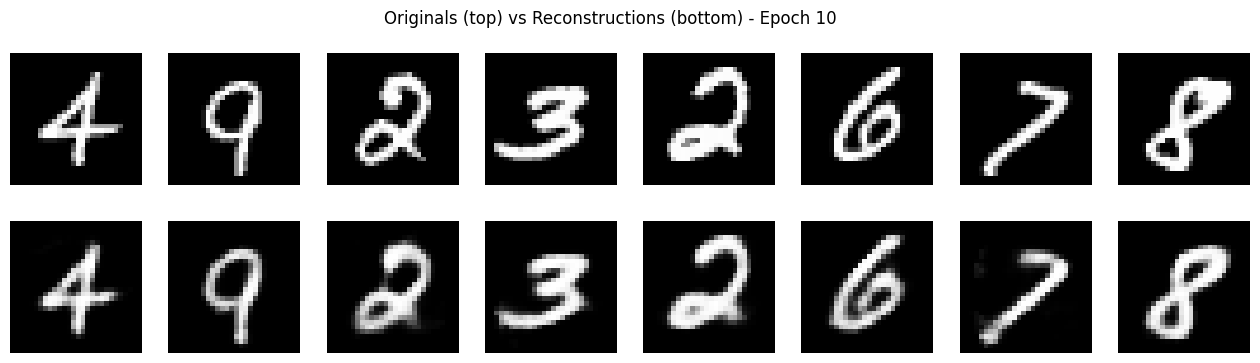

Epoch [11/30], Loss: 0.0325
Epoch [12/30], Loss: 0.0318
Epoch [13/30], Loss: 0.0311
Epoch [14/30], Loss: 0.0307
Epoch [15/30], Loss: 0.0302


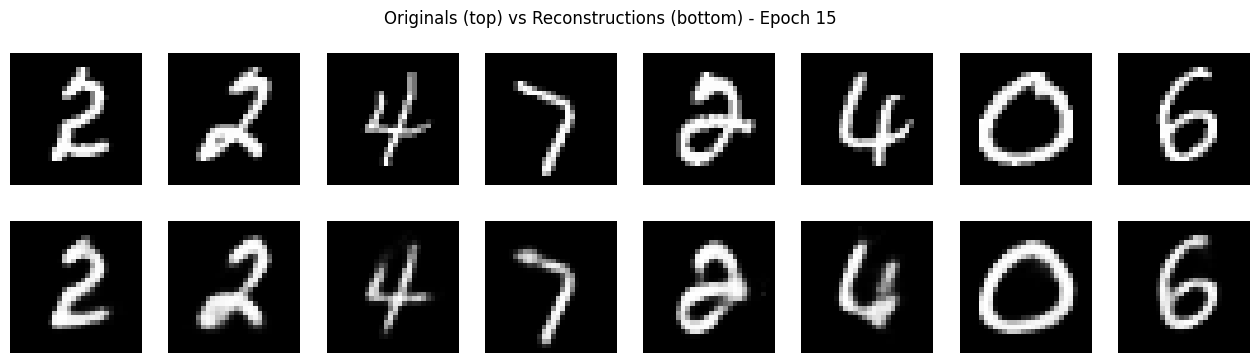

Epoch [16/30], Loss: 0.0296
Epoch [17/30], Loss: 0.0289
Epoch [18/30], Loss: 0.0286
Epoch [19/30], Loss: 0.0282
Epoch [20/30], Loss: 0.0279


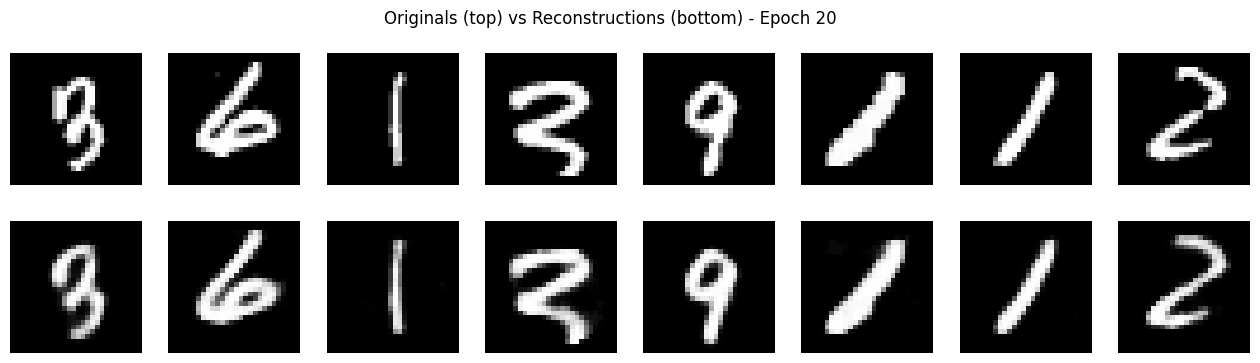

Epoch [21/30], Loss: 0.0277
Epoch [22/30], Loss: 0.0274
Epoch [23/30], Loss: 0.0271
Epoch [24/30], Loss: 0.0268
Epoch [25/30], Loss: 0.0265


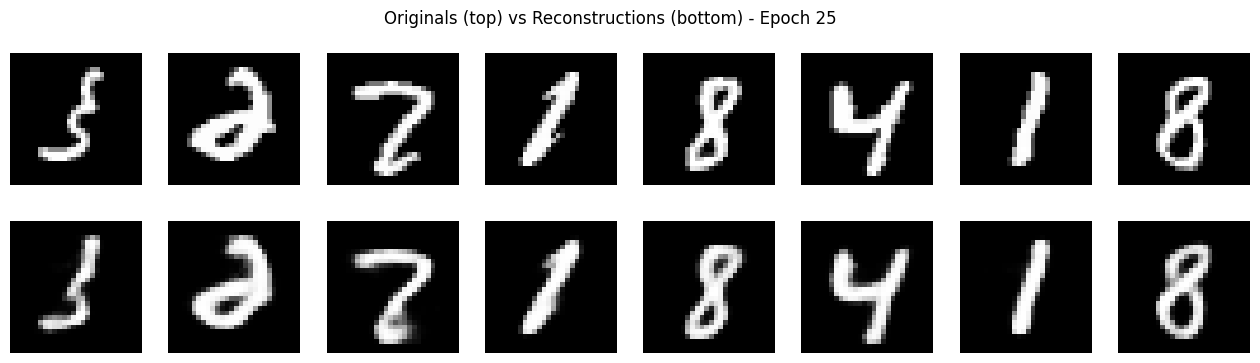

Epoch [26/30], Loss: 0.0262
Epoch [27/30], Loss: 0.0261
Epoch [28/30], Loss: 0.0259
Epoch [29/30], Loss: 0.0258
Epoch [30/30], Loss: 0.0257


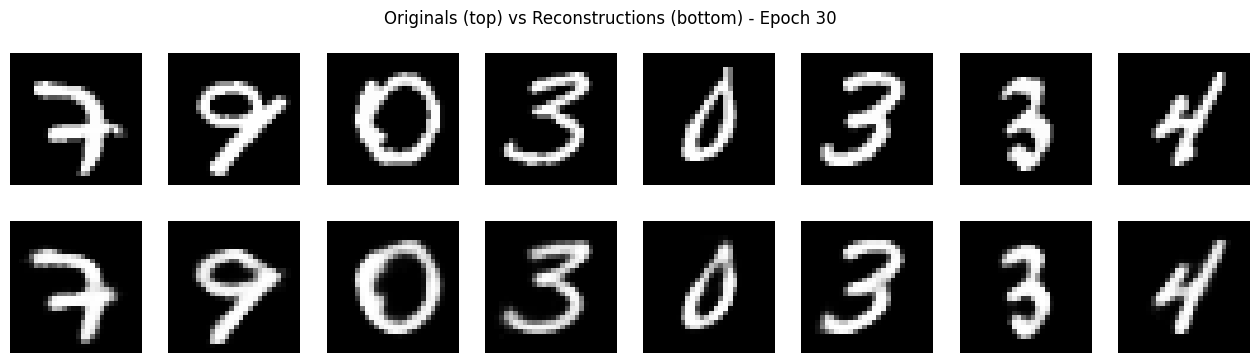

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparamètres
latent_dim = 64
batch_size = 64
n_epochs = 30
learning_rate = 0.001
image_size = 28 * 28  # MNIST images are 28x28
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Préparation des données MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Définition du Réseau de Koopman
class KoopmanNetwork(nn.Module):
    def __init__(self, image_size, latent_dim):
        super(KoopmanNetwork, self).__init__()
        
        # Encodeur : Projection vers l'espace latent
        self.encoder = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        
        # Matrice Koopman (transformation linéaire dans l'espace latent)
        self.koopman_matrix = nn.Linear(latent_dim, latent_dim, bias=False)
        
        # Décodeur : Reconstruction de l'image depuis l'espace latent
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Tanh()  # Normalisation entre -1 et 1
        )
        
    def forward(self, x):
        # Encoder
        latent = self.encoder(x)
        
        # Koopman projection
        latent_next = self.koopman_matrix(latent)
        
        # Decode
        reconstructed = self.decoder(latent_next)
        return latent, latent_next, reconstructed

# Initialisation du modèle
model = KoopmanNetwork(image_size, latent_dim).to(device)

# Fonction de perte et optimiseur
criterion = nn.MSELoss()  # On cherche à reconstruire les images
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement du modèle
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    
    for imgs, _ in dataloader:
        imgs = imgs.view(imgs.size(0), -1).to(device)  # Convertir en vecteurs
        optimizer.zero_grad()
        
        # Passer les données dans le modèle
        latent, latent_next, reconstructed = model(imgs)
        
        # Calcul des pertes
        loss_reconstruction = criterion(reconstructed, imgs)
        loss_latent_dynamics = criterion(latent_next, latent)  # Latent doit rester proche (Koopman)
        loss = loss_reconstruction + loss_latent_dynamics
        
        # Rétropropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/len(dataloader):.4f}")

    # Visualisation tous les 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            z, _, reconstructed = model(imgs[:8].to(device))
            fig, axes = plt.subplots(2, 8, figsize=(16, 4))
            for i in range(8):
                # Image originale
                axes[0, i].imshow(imgs[i].cpu().view(28, 28), cmap='gray')
                axes[0, i].axis('off')
                
                # Reconstruction
                axes[1, i].imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
                axes[1, i].axis('off')
            plt.suptitle(f"Originals (top) vs Reconstructions (bottom) - Epoch {epoch + 1}")
            plt.show()
